In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay


### Load processed data

In [7]:
DATA_PATH = Path("../data/processed/har_clean.csv")
df = pd.read_csv(DATA_PATH)

# Features/target
feature_cols = [c for c in df.columns if c not in ["subject_id", "activity_code", "activity", "split"]]
X = df[feature_cols]
y = df["activity"]

# Use the dataset's built-in split (recommended for HAR)
train_mask = df["split"] == "train"
test_mask = df["split"] == "test"

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

X_train.shape, X_test.shape

((7352, 561), (2947, 561))

### Baseline pipeline (Scaler → PCA → Logistic Regression)

In [8]:
baseline_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=65, random_state=42)),
    ("clf", LogisticRegression(max_iter=2000, n_jobs=None))
])

baseline_lr.fit(X_train, y_train)
pred = baseline_lr.predict(X_test)

print("Baseline LR + PCA")
print("Accuracy:", accuracy_score(y_test, pred))
print("Macro F1:", f1_score(y_test, pred, average="macro"))


Baseline LR + PCA
Accuracy: 0.9229725144214456
Macro F1: 0.9219538694144372


### Compare a few models

In [6]:
from sklearn.svm import LinearSVC
import time

models = {
    "LR + PCA(65)": baseline_lr,
    "LinearSVC + PCA(65)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=65, random_state=42)),
        ("clf", LinearSVC(max_iter=5000))
    ]),
    "RandomForest (50 trees)": RandomForestClassifier(
        random_state=42, n_estimators=50, n_jobs=-1
    ),
    "GradientBoosting (shallow)": GradientBoostingClassifier(
        random_state=42, n_estimators=100, max_depth=3
    )
}

results = []
for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    elapsed = time.time() - start

    results.append({
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "macro_f1": f1_score(y_test, y_pred, average="macro"),
        "seconds": round(elapsed, 2)
    })

pd.DataFrame(results).sort_values("macro_f1", ascending=False)

,model,accuracy,macro_f1,seconds
3,GradientBoosting (shallow),0.938242,0.937435,987.89
0,LR + PCA(65),0.922973,0.921954,1.22
2,RandomForest (50 trees),0.922294,0.921023,1.80
1,LinearSVC + PCA(65),0.917883,0.916648,0.66


### GridSearchCV for SVC + PCA

In [9]:
svc_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=42)),
    ("clf", SVC())
])

param_grid = {
    "pca__n_components": [50, 65, 80, 104, 120],
    "clf__kernel": ["rbf", "linear"],
    "clf__C": [0.1, 1, 10]
}

grid = GridSearchCV(
    svc_pipe,
    param_grid=param_grid,
    cv=5,
    scoring="f1_macro",
    n_jobs=1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV macro F1:", grid.best_score_)

Best params: {'clf__C': 10, 'clf__kernel': 'rbf', 'pca__n_components': 120}
Best CV macro F1: 0.9174715967181915


GridSearchCV was used to tune the SVC hyperparameters using 5-fold cross-validation and macro F1 score, ensuring robust model selection and generalization.

### Evaluate best model on test set

In [10]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test Macro F1:", f1_score(y_test, y_pred, average="macro"))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.9423142178486597
Test Macro F1: 0.9410287986333891

Classification report:

                    precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       537
           SITTING       0.94      0.89      0.91       491
          STANDING       0.91      0.94      0.93       532
           WALKING       0.95      0.97      0.96       496
WALKING_DOWNSTAIRS       0.96      0.90      0.93       420
  WALKING_UPSTAIRS       0.91      0.94      0.93       471

          accuracy                           0.94      2947
         macro avg       0.94      0.94      0.94      2947
      weighted avg       0.94      0.94      0.94      2947



### Confusion matrix

<Figure size 800x800 with 0 Axes>

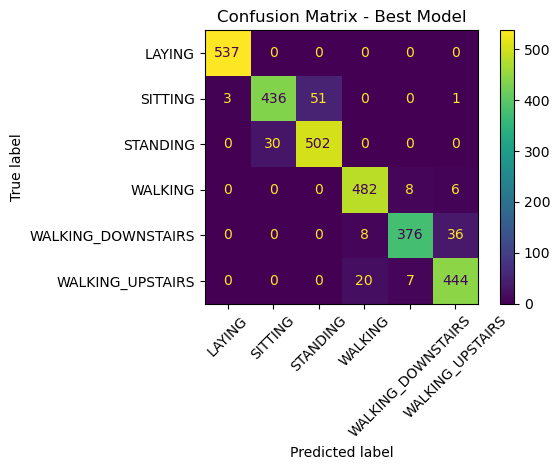

In [11]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, xticks_rotation=45)
plt.title("Confusion Matrix - Best Model")
plt.tight_layout()
plt.show()


The confusion matrix shows strong classification performance across all activities, with particularly high accuracy for static postures such as *LAYING*. Most misclassifications occur between biomechanically similar activities, such as *SITTING* vs *STANDING* and among the different walking-related classes. These errors are expected due to overlapping motion patterns and indicate reasonable model behavior rather than systematic failure.


### Save the trained pipeline (production step)

In [ ]:
import joblib

MODEL_PATH = Path("../models/best_model.joblib")
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)

joblib.dump(best_model, MODEL_PATH)
print("Saved model to:", MODEL_PATH.resolve())